# How to Use LKIS
**By: Victor Ardulov**

In this notebook I will effectively break down [the main training scrip which can be run via CLI](../train.py) and then similarly how [predictions can be made](../predict.py).

Specifically the example will go through the Lorenz example provided by the original authors of the method.

For the purposes of this tutorial no CUDA will be assumed, however the implementation in `train.py` allows you to set the `--gpu` flag which will use a CUDA device.

## Imports

First things first we need to import what we'll be using, namely we'll import some libraries for loading the data (NumPy) some libraries for plotting (Pandas, MatPlotLib, and Seaborn) and we'll import PyTorch optimization stuff so that we can utilize SGD.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.optim import SGD
from torch import manual_seed

np.random.seed(216)
manual_seed(216)
sns.set_context("notebook")

Next we need to import the dataset batching class, the KIS network class. Additionally we'll import the classes from `loss.py` and in this case we'll import both, but only one will really be used to compute the gradients (both will be used but only the combined loss output tensor is used for the network update), the other will be used to demonstrate that the loss is in fact diminishing in both cases.

In [2]:
#this is some path magic so that we can import stuff from the parent directory
import sys
sys.path.extend(["../"])

from lkis import TimeSeriesBatchMaker, KoopmanInvariantSubspaceLearner
from losses import combined_loss, rss_loss

## Loading Data

Next let's load in our training and validation data, which are stored as NumPy files in the parent directory

In [3]:
data_train = np.load("../train.npy")
data_val = np.load("../val.npy")

Let's take a look at what we're working with here

Text(0.5, 0, '$t$')

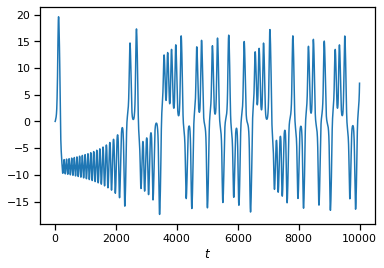

In [4]:
sns.lineplot(x=list(range(data_train.shape[0])), y=data_train)
plt.xlabel(r"$t$")

## Preparing the data for training

So let $y_t \in \mathbb{R}^d$ be our $d$-dimensional value that we are observing in our data. In this specific case $d = 1$ since our signal only has one-value per time step.

Recall that given some "delay" $L$ we construct a window for which the netowrk is trying to reconstruct the signal in $Y = [y_0, ..., y_T]$. Really what this means is that for our network that we are trying to learn, and consequently what our data needs to look like is:

$$KIS([y_t, y_t-1, y_t-2, ... y_{t-L}]) \approx y_t$$

So we'll use the batch loader to get our data into the form necessary to do this with a delay of 5.

The `TimeSeriesBatchMaker` can also handle splitting the data into learning batches (this might help with batch normalization) but by default it will just return all the data a single batch (like what we'll do here)

In [5]:
delay = 5
train_batch_loader = TimeSeriesBatchMaker(y=data_train, max_lag=delay)
val_batch_loader = TimeSeriesBatchMaker(y=data_val, max_lag=delay)

In [6]:
y_td, y_true = next(train_batch_loader)
y_td_val, y_true_val = next(val_batch_loader)

In [7]:
y_td[:5]

tensor([[0.0758, 0.0492, 0.0371, 0.0249, 0.0125],
        [0.1018, 0.0758, 0.0492, 0.0371, 0.0249],
        [0.1272, 0.1018, 0.0758, 0.0492, 0.0371],
        [0.1521, 0.1272, 0.1018, 0.0758, 0.0492],
        [0.1769, 0.1521, 0.1272, 0.1018, 0.0758]])

In [8]:
y_true[:5]

tensor([[0.0758],
        [0.1018],
        [0.1272],
        [0.1521],
        [0.1769]])

You'll notice that the first column of the tensor `y_td` is always equivalent to the `y_true` which is where the explanation that this is a fancy auto-encoder comes in, effectively we're utilizing, but we're trying to leverage the local history to try to predict the underlying state $s_t$ which unknown to us

## Let's get ready to model

Now that we have our data in a batch friendly format let's start setting up the remaining elements of necessary to start training. The first of which is of course choosing the model. For the sake of this experiment, we'll assume that the dimension of the hidden space is $5$ (more formally $s_t \in S = \mathbb{R}^5$) and that $g(s_t) \in G = \mathbb{R}$ is also a single dimensionnal projection.

In [9]:
state_space_dim = 5
g_space_dim = obs_space_dim = 1
lkis = KoopmanInvariantSubspaceLearner(
    observable_dim=obs_space_dim,
    latent_dim=state_space_dim,
    intermediate_observable=g_space_dim,
    delay=delay
)

Next we'll set up the SGD optimizer and set a learning rate of `1E-3`

In [10]:
learning_rate = 1E-3
optimizer = SGD(lkis.parameters(), lr=learning_rate)

## Time to train

Now we just have to set up the loop to start training the network. In this case we're not going to do any early stopping but just know that the point of the validation set is there to combat over-fitting

In [11]:
losses = {
    "combined loss training": [],
    "combined loss validation": [],
    "RSS loss training": [],
    "RSS loss validation": []
}
epochs = 125

In [12]:
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = 0
    
    g_pred, y_pred = lkis(y_td)
    g_0 = g_pred[:-1]
    g_1 = g_pred[1:]
    
    train_loss = combined_loss(y_pred=y_pred, y_true=y_true, g_0=g_0, g_1=g_1)
    train_loss.backward()
    optimizer.step()
    
    train_rss = rss_loss(g_0, g_1)
    
    g_pred, y_pred = lkis(y_td_val)
    g_0 = g_pred[:-1]
    g_1 = g_pred[1:]
    
    val_loss = combined_loss(y_pred=y_pred, y_true=y_true_val, g_0=g_0, g_1=g_1)
    val_rss = rss_loss(g_0, g_1)
    
    print(
        f"Completed epoch: {epoch+1}/{epochs}:\n"
        f"training-loss: {train_loss.item():0.6f} | training-rss: {train_rss.item():0.6f} |"
        f" validation-loss: {val_loss.item():0.6f} | validation-rss: {val_rss.item():0.6f}"
    )
    losses["combined loss training"].append(train_loss.item())
    losses["RSS loss training"].append(train_rss.item())
    losses["combined loss validation"].append(val_loss.item())
    losses["RSS loss validation"].append(val_rss.item())
    

Completed epoch: 1/125:
training-loss: 81.777641 | training-rss: 7.282784 | validation-loss: 71.104744 | validation-rss: 3.584921
Completed epoch: 2/125:
training-loss: 80.968452 | training-rss: 6.769845 | validation-loss: 70.613007 | validation-rss: 3.339666
Completed epoch: 3/125:
training-loss: 80.203560 | training-rss: 6.301910 | validation-loss: 70.141388 | validation-rss: 3.115385
Completed epoch: 4/125:
training-loss: 79.477669 | training-rss: 5.874015 | validation-loss: 69.687355 | validation-rss: 2.909826
Completed epoch: 5/125:
training-loss: 78.786201 | training-rss: 5.481913 | validation-loss: 69.248672 | validation-rss: 2.721018
Completed epoch: 6/125:
training-loss: 78.125114 | training-rss: 5.121871 | validation-loss: 68.823410 | validation-rss: 2.547280
Completed epoch: 7/125:
training-loss: 77.490845 | training-rss: 4.790632 | validation-loss: 68.409805 | validation-rss: 2.387126
Completed epoch: 8/125:
training-loss: 76.880264 | training-rss: 4.485349 | validation-los

In [14]:
results = pd.DataFrame(losses)

<AxesSubplot:>

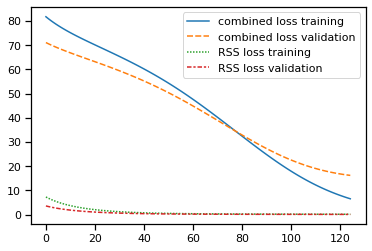

In [15]:
sns.lineplot(data=results)

And there you have it you've trained Koopman Invariant Subspace Model!

To-do:

* [ ] how do you actually look at what the model learned as use it to evaluate the modelling approach
* [ ] can you use this model to simulate a model, how much data forward and back does the model need
* [ ] extend to incorporate KoopmanInvariantControlledSubspaces.